The transfer learning algorithm described in the "Bayesian transfer learning between Gaussian process regression tasks" paper is attempted here

The source task is a chirp signal that is realized over 4 seconds. The signal is sampled uniformly 200 times.

The target task is the same chirp signal realized only for the first second. It is sampled uniformly 50 times.


The knowledge learnt in the source task will be transferred to the target task in order to provide more accurate predictions of the signal in and around the target task's time domain

In [1]:
#imports 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v2.enable_v2_behavior()
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

In [2]:
#defining the function that will be called to produce a chirp signal
# it takes [x-points, chirp rate, initial frequency]
def chirp(x, c, f):
    ft = (x*c) + f
    c_sig = np.sin(2*np.pi*ft*x)
    return c_sig

In [173]:
#Declare the operating conditions
SNR = 5;
signal_amp = 1;
Ps = signal_amp**2
Pn = (Ps*10)**(-SNR/10)
chirp_rate = 0.5;
num_points = 200;

#instantiate the observation points of the source
x_source = (np.arange(0,4,4/num_points)).astype(np.float64)
x_source = x_source.reshape(len(x_source),1)

#target observation points
x_target_train = np.arange(0,1,1/50).astype(np.float64)
x_target_train = x_target_train.reshape(len(x_target_train), 1)


#y values for training the source and target models
y_source = chirp(x_source, chirp_rate, 0.5) + (np.random.normal(0, np.sqrt(Pn), len(x_source))).reshape(len(x_source),1)
y_source = y_source.reshape(len(y_source))

y_target_train = chirp(x_target_train, chirp_rate, 0.5) + (np.random.normal(0,np.sqrt(Pn),len(x_target_train))).reshape(len(x_target_train),1)
y_target_train = y_target_train.reshape(len(y_target_train))


#index points that will be used to constitute both the observed and unobserved points
index_points = np.arange(0,4,4/400).astype(np.float64)
index_points = index_points.reshape(400,1)
y_index = (chirp(index_points, chirp_rate, 0.5)).reshape(400,)

In [174]:
#setting some values for kernel hyperparameter optimization that will be used later
num_iters = 200
optimizer = tf.optimizers.Adam(learning_rate=0.01)
num_samples = 40;

-----------------------------
The optimal model as described in the paper:

$M^{o}(f^{*}|x^{*},x,y,F_{s}) \propto F(f^{*} | x^{*},x,y) \times exp[ \int log(F(y^{*}|f^{*},x^{*})) F_{s}(y^{*}|x_{s}^{*},x_{s},y_{s}) dy^{*}]$


Each of these components will be obtained:

$F(f^{*} | x^{*},x,y)$

$F(y^{*}|f^{*},x^{*})$

$F_{s}(y^{*}|x_{s}^{*},x_{s},y_{s})$


--------------------------------------

Construct the Target model using target knowledge only:
----------------------

Obtain: $F(f^{*} | x^{*},x,y)$ and $F(y^{*}|f^{*},x^{*})$
------------------------

In [175]:
#define the gp model with the kernel function
def build_target_gp_model(amplitude, length_scale, observation_noise_variance, bias_variance, slope_variance):

    kernel_1 = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
    kernel_2 = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)
    kernel_3 = tfk.Linear(bias_variance=bias_variance, slope_variance=slope_variance)
    model_kernel = (kernel_1*kernel_2)+kernel_3

    return tfd.GaussianProcess(
      kernel = model_kernel,
      index_points = x_target_train,
      observation_noise_variance = observation_noise_variance)


#instantiate the joint distribution for the model variables
gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'slope_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'bias_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_target_gp_model,
})


#instantiate the variables themselves and constrain them to be positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var_target = tfp.util.TransformedVariable(
    initial_value = 1.0,
    bijector=constrain_positive,
    name='amplitude',
    dtype=tf.float64)

length_scale_var_target = tfp.util.TransformedVariable(
    initial_value= 1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=tf.float64)

observation_noise_variance_var_target = tfp.util.TransformedVariable(
    initial_value= 1.,
    bijector=constrain_positive,
    name='observation_noise_variance',
    dtype=tf.float64)

slope_variance_var_target = tfp.util.TransformedVariable(
    initial_value= 1.,
    bijector=constrain_positive,
    name='slope_variance',
    dtype=tf.float64)

bias_variance_var_target = tfp.util.TransformedVariable(
    initial_value= 1.,
    bijector=constrain_positive,
    name='bias_variance',
    dtype=tf.float64)

#These are the variables that will need to be trained
trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var_target,
                       length_scale_var_target,
                       observation_noise_variance_var_target,
                       slope_variance_var_target,
                       bias_variance_var_target]]


#log loss of joint distribution 
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance, slope_variance, bias_variance):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'slope_variance': slope_variance,
      'bias_variance': bias_variance,
      'observations': y_target_train
    })


#perform Adam optimization for the trainable variables
#loss is defined by calling the tareget_log_prob function - Log Loss
for j in range(num_iters):
    with tf.GradientTape() as tape:
        loss = -target_log_prob(amplitude_var_target, length_scale_var_target, observation_noise_variance_var_target,
                                slope_variance_var_target, bias_variance_var_target)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))


#Create kernel mixture function using the optimized variables        
opt_kernel_1_target = tfk.ExponentiatedQuadratic(amplitude = amplitude_var_target, length_scale = length_scale_var_target)
opt_kernel_2_target = tfk.ExpSinSquared(amplitude = amplitude_var_target, length_scale = length_scale_var_target)
opt_kernel_3_target = tfk.Linear(slope_variance=slope_variance_var_target, bias_variance = bias_variance_var_target)
optimized_kernel_target = (opt_kernel_1_target*opt_kernel_2_target) + opt_kernel_3_target


#create the GPR model 
gprm_target = tfd.GaussianProcessRegressionModel(
    kernel = optimized_kernel_target,
    index_points = index_points,
    observation_index_points = x_target_train,
    observations = y_target_train,
    observation_noise_variance = observation_noise_variance_var_target,
    predictive_noise_variance=0.)


In [176]:
#sample from the posterior distribution
samples = gprm_target.sample(num_samples)

#calculate the euclidean norm error between the samples and the true underlying signal
norm_error = np.zeros([40])
for i in range(num_samples):
    norm_error[i] = np.sqrt(np.sum((samples[i] - chirp(index_points, chirp_rate, 0.5).reshape(400))**2))
    
mc_norm_error_target = np.mean(norm_error)

#mean values from the GPR model
mean_fn_target = gprm_target.mean_fn(index_points)

Text(0.5, 1.0, 'Target No Transfer')

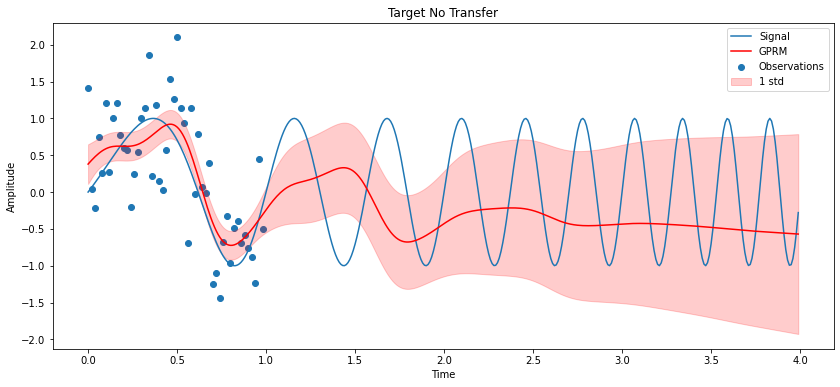

In [444]:
fig1 = plt.figure(figsize = (14,6))
plt.plot(index_points, y_index, label = 'Signal')
plt.plot(index_points, mean_fn_target, label = 'GPRM', c='r')
plt.scatter(x_target_train, y_target_train, label='Observations')
plt.fill_between(index_points.reshape(-1),mean_fn_target + gprm_target.stddev(), 
                 mean_fn_target - gprm_target.stddev(), color = 'r', alpha = 0.2, label = '1 std')

leg = plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Target No Transfer')


--------------------------
$F(f^{*} | x^{*},x,y) \sim \mathcal{N}(m,k)$
----------------------------
-------------------------

In [317]:
#calculate the mean and covariance function of the distribution

mean_fn_target_f = gprm_target.mean_fn(index_points)
covariance_target_f = gprm_target.covariance()

#convert from tensorflow objects to numpy arrays for later calculations
mean_fn_target_f = np.array(mean_fn_target_f);
covariance_target_f = np.array(covariance_target_f)

In [179]:
covariance_target_f

<tf.Tensor: shape=(400, 400), dtype=float64, numpy=
array([[ 0.07230967,  0.06802557,  0.06331953, ..., -0.06306403,
        -0.06323557, -0.06340715],
       [ 0.06802557,  0.06475853,  0.06104169, ..., -0.05518525,
        -0.05533563, -0.05548595],
       [ 0.06331953,  0.06104169,  0.05830451, ..., -0.04763437,
        -0.04776457, -0.04789465],
       ...,
       [-0.06306403, -0.05518525, -0.04763437, ...,  1.82531293,
         1.8282844 ,  1.82960357],
       [-0.06323557, -0.05533563, -0.04776457, ...,  1.8282844 ,
         1.83293522,  1.83591903],
       [-0.06340715, -0.05548595, -0.04789465, ...,  1.82960357,
         1.83591903,  1.84058219]])>


$F(y^{*}|f^{*},x^{*})\sim \mathcal{N}(m,k+\sigma^{2}I)$
-------------------

In [318]:
#calculate the mean and covariance function of the distribution
#mean for y and f are the same

mean_fn_target_y = gprm_target.mean_fn(index_points)
covariance_target_y = gprm_target.covariance() + (
    observation_noise_variance_var_target.numpy()*np.identity(len(index_points)))

mean_fn_target_y = np.array(mean_fn_target_y);
covariance_target_y = np.array(covariance_target_y)

In [181]:
covariance_target_y

<tf.Tensor: shape=(400, 400), dtype=float64, numpy=
array([[ 0.43202989,  0.06802557,  0.06331953, ..., -0.06306403,
        -0.06323557, -0.06340715],
       [ 0.06802557,  0.42447875,  0.06104169, ..., -0.05518525,
        -0.05533563, -0.05548595],
       [ 0.06331953,  0.06104169,  0.41802472, ..., -0.04763437,
        -0.04776457, -0.04789465],
       ...,
       [-0.06306403, -0.05518525, -0.04763437, ...,  2.18503314,
         1.8282844 ,  1.82960357],
       [-0.06323557, -0.05533563, -0.04776457, ...,  1.8282844 ,
         2.19265544,  1.83591903],
       [-0.06340715, -0.05548595, -0.04789465, ...,  1.82960357,
         1.83591903,  2.20030241]])>

-----------------------------

Construct the Source Model
---------------------------------------


Obtain: $F_{s}(y^{*}|x_{s}^{*},x_{s},y_{s})$
------------------------------

------------------------------

Constructing the model is done the same as before. However, in this instance, the source is assumed to have access to abundant knowledge. Therefore, several models are constructed based on multiple sets of the observations and the model which minimizes the euclidean norm error between the constructed mean line and the underlying signal is used.  

In [182]:
def build_source_gp_model(amplitude, length_scale, observation_noise_variance, bias_variance, slope_variance):

    kernel_1 = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
    kernel_2 = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)
    kernel_3 = tfk.Linear(bias_variance=bias_variance, slope_variance=slope_variance)
    model_kernel = (kernel_1*kernel_2)+kernel_3

    return tfd.GaussianProcess(
      kernel = model_kernel,
      index_points = x_source,
      observation_noise_variance = observation_noise_variance)


gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'slope_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'bias_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_source_gp_model,
})



constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var_source = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=tf.float64)

length_scale_var_source = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=tf.float64)

observation_noise_variance_var_source = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance',
    dtype=tf.float64)

slope_variance_var_source = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='slope_variance',
    dtype=tf.float64)

bias_variance_var_source = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='bias_variance',
    dtype=tf.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var_source,
                       length_scale_var_source,
                       observation_noise_variance_var_source,
                       slope_variance_var_source,
                       bias_variance_var_source]]



#Optimize kernel hyperparameters for 10 different sets of observations
#calculate the errors

sample_amp = np.zeros([10],dtype = np.float64);
sample_len = np.zeros([10],dtype = np.float64);
sample_obs_nv = np.zeros([10],dtype = np.float64);
sample_slope = np.zeros([10],dtype = np.float64);
sample_bias = np.zeros([10],dtype = np.float64);
mc_norm_error_source_samples = np.zeros([10],dtype = np.float64);

for k in range(10):

    y_source = chirp(x_source, chirp_rate, 0.5) + (np.random.normal(0, np.sqrt(Pn), len(x_source))).reshape(len(x_source),1)
    y_source = y_source.reshape(len(y_source))


    @tf.function(autograph=False, experimental_compile=False)
    def target_log_prob(amplitude, length_scale, observation_noise_variance, slope_variance, bias_variance):
        return gp_joint_model.log_prob({
          'amplitude': amplitude,
          'length_scale': length_scale,
          'observation_noise_variance': observation_noise_variance,
          'slope_variance': slope_variance,
          'bias_variance': bias_variance,
          'observations': y_source
        })


    for j in range(num_iters):
        with tf.GradientTape() as tape:
            loss = -target_log_prob(amplitude_var_source, length_scale_var_source, observation_noise_variance_var_source,
                                    slope_variance_var_source, bias_variance_var_source)
            grads = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))


    sample_amp[k] = amplitude_var_source.numpy();
    sample_len[k] = length_scale_var_source.numpy();
    sample_obs_nv[k] = observation_noise_variance_var_source.numpy();
    sample_slope[k] = slope_variance_var_source.numpy();
    sample_bias[k] = bias_variance_var_source.numpy();

    opt_kernel_1_source = tfk.ExponentiatedQuadratic(amplitude = amplitude_var_source, length_scale = length_scale_var_source)
    opt_kernel_2_source = tfk.ExpSinSquared(amplitude = amplitude_var_source, length_scale = length_scale_var_source)
    opt_kernel_3_source = tfk.Linear(slope_variance=slope_variance_var_source, bias_variance = bias_variance_var_source)
    optimized_kernel_source = (opt_kernel_1_source*opt_kernel_2_source) + opt_kernel_3_source

    
    inter_error = np.zeros([10])
    #test these values for the hyperparameters on gp constructions from 10 different
    # sets of observations
    for n in range(10):

        y_source = chirp(x_source, chirp_rate, 0.5) + (np.random.normal(0, np.sqrt(Pn), len(x_source))).reshape(len(x_source),1)
        y_source = y_source.reshape(len(y_source))


        gprm_source = tfd.GaussianProcessRegressionModel(
            kernel = optimized_kernel_source,
            index_points = index_points,
            observation_index_points = x_source,
            observations = y_source,
            observation_noise_variance = observation_noise_variance_var_source,
            predictive_noise_variance=0.)


        samples_source = gprm_source.sample(num_samples)
        norm_error = np.zeros([num_samples])

        #sample from the posterior distribution
        for i in range(num_samples):
            norm_error[i] = np.sqrt(np.sum((samples_source[i] - chirp(index_points, chirp_rate, 0.5).reshape(400))**2))

        inter_error[n] = np.mean(norm_error)
    
    mc_norm_error_source_samples[k] = np.mean(inter_error)

In [445]:
#construct the kernel function using the values which correspond to
#model which minimized error

optimum_khp = mc_norm_error_source_samples.argmin()
    
opt_kernel_1_source = tfk.ExponentiatedQuadratic(amplitude = sample_amp[optimum_khp], 
                                                 length_scale = sample_len[optimum_khp])
opt_kernel_2_source = tfk.ExpSinSquared(amplitude = sample_amp[optimum_khp], 
                                        length_scale = sample_len[optimum_khp])
opt_kernel_3_source = tfk.Linear(slope_variance = sample_slope[optimum_khp], 
                                 bias_variance = sample_bias[optimum_khp])

optimized_kernel_source = (opt_kernel_1_source*opt_kernel_2_source) + opt_kernel_3_source

#construct the GPR model with the optimized kernel
gprm_source = tfd.GaussianProcessRegressionModel(
            kernel = optimized_kernel_source,
            index_points = index_points,
            observation_index_points = x_source,
            observations = y_source,
            observation_noise_variance = observation_noise_variance_var_source,
            predictive_noise_variance=0.)

mean_line_source = gprm_source.mean_fn(index_points)

Text(0.5, 1.0, 'Source Model')

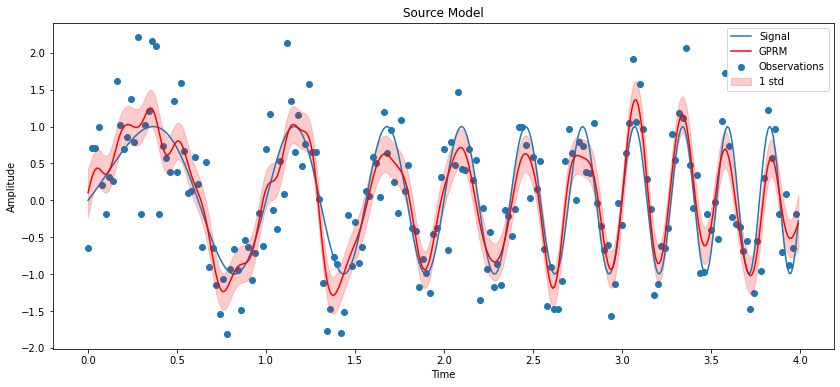

In [446]:
fig3 = plt.figure(figsize = (14,6))
plt.plot(index_points, y_index, label = 'Signal')
plt.plot(index_points, mean_line_source, label = 'GPRM', c='r')
plt.scatter(x_source, y_source, label='Observations')
plt.fill_between(index_points.reshape(-1),mean_line_source + gprm_source.stddev() , 
                 mean_line_source - gprm_source.stddev(), color = 'r', alpha = 0.2, label='1 std')

leg = plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Source Model')


Predictions conditioned on source knowledge:


$F_{s}(y^{*}|x_{s}^{*},x_{s},y_{s}) \sim \mathcal{N}(m,k+\sigma^{2}I)$
-------------------------

In [319]:
#calculate the mean and covariance function of the distribution

mean_fn_source = gprm_source.mean_fn(index_points)
covariance_source = (gprm_source.covariance() + (
    observation_noise_variance_var_source.numpy()*np.identity(len(index_points))))


mean_fn_source = np.array(mean_fn_source);
covariance_source = np.array(covariance_source)

In [187]:
covariance_source

<tf.Tensor: shape=(400, 400), dtype=float64, numpy=
array([[ 3.79846452e-01,  9.49832753e-02,  7.68497856e-02, ...,
        -3.19719585e-04, -4.43265570e-04, -5.91912790e-04],
       [ 9.49832753e-02,  3.56572917e-01,  7.68812741e-02, ...,
        -2.28530615e-04, -3.16896828e-04, -4.23221192e-04],
       [ 7.68497856e-02,  7.68812741e-02,  3.42511574e-01, ...,
        -1.57479305e-04, -2.18432220e-04, -2.91776798e-04],
       ...,
       [-3.19719585e-04, -2.28530615e-04, -1.57479305e-04, ...,
         3.57113872e-01,  9.57254895e-02,  9.96684149e-02],
       [-4.43265570e-04, -3.16896828e-04, -2.18432220e-04, ...,
         9.57254895e-02,  3.80864788e-01,  1.24376098e-01],
       [-5.91912790e-04, -4.23221192e-04, -2.91776798e-04, ...,
         9.96684149e-02,  1.24376098e-01,  4.15396267e-01]])>

---------------------------
Optimal Model:

$M^{o}(f^{*}|x^{*},x,y,F_{s}) = \mathcal{N}(f^{*}; m^{o}_{n}(x^{*}),k^{o}_{n}(x^{*}x^{*}))$
-----------------------

 

--------------------------------------------


-------------------------------
$m^{o}_{n}(x) = m_{n}(x) + k_{n}(x,x^{*}) \times (k_{n}(x^{*},x^{*}) + \sigma^{2}I_{n*})^{-1} (m_{s,n}(x^{*}_{s}) - m_{n}(x^{*}))$


First, I am calculting the optimum mean function for both observed and unobserved data together 

$K(X,X) = \begin{bmatrix}
k(x,x) & k(x,x^{*})\\
k(x^{*},x) & k(x^{*},x^{*}) 
\end{bmatrix}$

$m(X) = m(x) + m(x^{*})$ 

$m^{o}_{n}(x) = m(X) + K(X,X) \times (K(X,X) + \sigma^{2}I)^{-1} (m_{s}(X_{s}) - m(X))$

In [188]:
#whole mean function method
mean_diff = mean_fn_source - mean_fn_target_f;


mean_fn_opt = mean_fn_target_f + (
    np.matmul(covariance_target_f, (
        np.matmul(np.linalg.inv(covariance_target_y), mean_diff))
             )
)

Now the equation is followed strictly, breaking the mean function into observed and unobserved


$m^{o}_{n}(x) = m_{n}(x) + k_{n}(x,x^{*}) \times (k_{n}(x^{*},x^{*}) + \sigma^{2}I_{n*})^{-1} (m_{s,n}(x^{*}_{s}) - m_{n}(x^{*}))$

The following equation is my interpretation of how the above equation would translate to unobserved values 
$m^{o}_{n}(x^{*}) = m_{n}(x^{*}) + k_{n}(x^{*},x^{*}) \times (k_{n}(x^{*},x^{*}) + \sigma^{2}I_{n*})^{-1} (m_{s,n}(x^{*}_{s}) - m_{n}(x^{*}))$


In [321]:
#Finding the indices where observations have and have not been made

obs_pred_intersec = np.intersect1d(x_target_train, index_points)
observ_olap_loc = np.where(index_points == obs_pred_intersec)
observ_olap_loc = observ_olap_loc[0]

exclusion = np.setdiff1d(index_points, x_target_train)
not_observed_loc = np.where(index_points == exclusion)
not_observed_loc = not_observed_loc[0]

In [383]:
#calculating kernel function components needed in equation

x_x_star_locs = np.array(np.meshgrid(observ_olap_loc, not_observed_loc)).T.reshape(-1, 2)
k_x_x_star = covariance_target_f[x_x_star_locs[:,0], x_x_star_locs[:,1]]
k_x_x_star = k_x_x_star.reshape(50,350)

x_star_x_star_locs = np.array(np.meshgrid(not_observed_loc, not_observed_loc)).T.reshape(-1, 2)
k_x_star_x_star = covariance_target_f[x_star_x_star_locs[:,0], x_star_x_star_locs[:,1]]
k_x_star_x_star = k_x_star_x_star.reshape(350,350)

k_x_star_x_star_noise = k_x_star_x_star+ (observation_noise_variance_var_source.numpy()*np.identity(350))

#difference between the mean at the unobserved points for the source and target models
mean_diff = mean_fn_source[not_observed_loc] - mean_fn_target_f[not_observed_loc];

In [387]:
#calculate the optimum mean for the observed points

mean_opt_observed = mean_fn_target_f[observ_olap_loc]+ (np.matmul(
    k_x_x_star, np.matmul(
        np.linalg.inv(k_x_star_x_star_noise), mean_diff)
    ))

In [388]:
#calculate the optimum mean for the unobserved points

mean_opt_unobserved = mean_fn_target_f[not_observed_loc] + (np.matmul(
    k_x_star_x_star, np.matmul(
        np.linalg.inv(k_x_star_x_star_noise), mean_diff)
    ))

In [406]:
#merge the means for observed and unobserved into their appropriate index locations
mean_fn_opt2 = np.zeros(400)
mean_fn_opt2[observ_olap_loc] = mean_opt_observed
mean_fn_opt2[not_observed_loc] = mean_opt_unobserved

Now calculate the kernel function of the optimum model 

$k^{o}_{n}(x,x') = k_{n}(x,x') - k_{n}(x,x^{*}) \times (k_{n}(x^{*},x^{*}) + \sigma^{2}I_{n*})^{-1}  k_{n}(x^{*},x')$

Text(0.5, 1.0, 'TL Model 1')

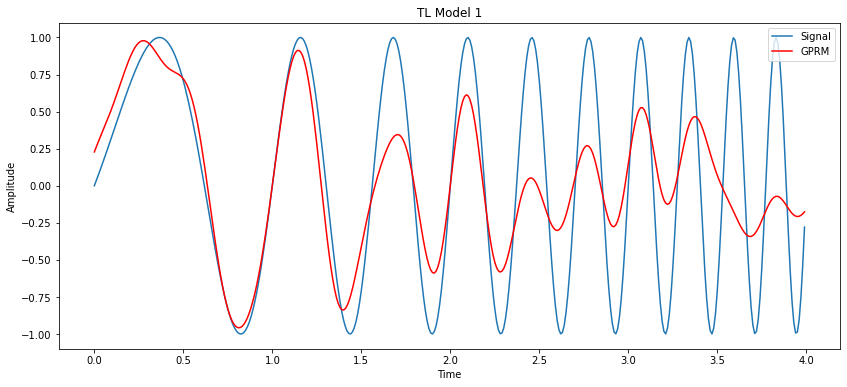

In [447]:
fig4 = plt.figure(figsize = (14,6))
plt.plot(index_points, y_index, label = 'Signal')
plt.plot(index_points, mean_fn_opt, label = 'GPRM', c='r')

#plt.fill_between(index_points.reshape(-1),mean_fn_opt + gprm_source.stddev() , 
 #                mean_line_source - gprm_source.stddev(), color = 'r', alpha = 0.2)

leg = plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('TL Model 1')

Text(0.5, 1.0, 'TL Model')

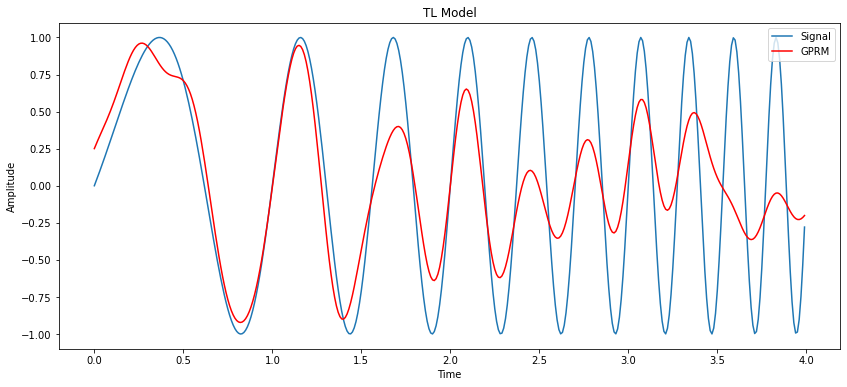

In [417]:
fig5 = plt.figure(figsize = (14,6))
plt.plot(index_points, y_index, label = 'Signal')
plt.plot(index_points, mean_fn_opt2, label = 'GPRM', c='r')

#plt.fill_between(index_points.reshape(-1),mean_fn_opt + gprm_source.stddev() , 
 #                mean_line_source - gprm_source.stddev(), color = 'r', alpha = 0.2)

leg = plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('TL Model 2')


4 models being assessed are:
    Source with no transfer (SNT)
    Target no transfer (TNT)
    Transfer model 1 (TSFR1)
    Transfer model 2 (TSFR2)
    
First assessing the ability of each model to predict every index value for the first 1.5 seconds

In [448]:
error_SNT = np.sqrt(np.sum((mean_fn_source[:150] - y_index[:150])**2))
error_TNT = np.sqrt(np.sum((mean_fn_target_f[:150] - y_index[:150])**2))
error_TSFR1 = np.sqrt(np.sum((mean_fn_opt[:150] - y_index[:150])**2))
error_TSFR2 = np.sqrt(np.sum((mean_fn_opt2[:150] - y_index[:150])**2))

In [449]:
print("SNT, TNT, TSFR1, TSFR2")
print(error_SNT.round(3), error_TNT.round(3), error_TSFR1.round(3), error_TSFR2.round(3))

SNT, TNT, TSFR1, TSFR2
2.62 6.232 1.85 1.917


The models are now assessed on how well they predict the unobserved values only, again for the first 1.5 seconds. 

In [450]:
# how does error for only the unobserved parts weigh up

error_SNT_pred = np.sqrt(np.sum((mean_fn_source[not_observed_loc[:100]] - y_index[not_observed_loc[:100]])**2))
error_TNT_pred = np.sqrt(np.sum((mean_fn_target_f[not_observed_loc[:100]] - y_index[not_observed_loc[:100]])**2))
error_TSFR1_pred = np.sqrt(np.sum((mean_fn_opt[not_observed_loc[:100]] - y_index[not_observed_loc[:100]])**2))
error_TSFR2_pred = np.sqrt(np.sum((mean_fn_opt2[not_observed_loc[:100]] - y_index[not_observed_loc[:100]])**2))

In [451]:
print("SNT, TNT, TSFR1, TSFR2")
print(error_SNT_pred.round(3), error_TNT_pred.round(3), error_TSFR1_pred.round(3), error_TSFR2_pred.round(3))

SNT, TNT, TSFR1, TSFR2
2.287 6.042 1.621 1.633
